In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import os
import shapely

In [2]:
swb_layer_path = os.path.join(
    os.environ['DATA'],
    'ponds_and_wells',
    'gobindpur_swb2.json'
    )

ponds_layer_path = os.path.join(
    os.environ['DATA'],
    'ponds_and_wells/output/17/gobindpur/gobindpur_COMBINED_GEOMETRY',
    'gobindpur_COMBINED_GEOMETRY.shp'
    )

mws_layer_path = os.path.join(
    os.environ['DATA'],
    'ponds_and_wells',
    'gobindpur_mws.json'
    )

admin_boundary_layer_path = os.path.join(
    os.environ['DATA'],
    'ponds_and_wells',
    'gobindpur_boundary.geojson'
    )


In [3]:
ponds_gdf = gpd.read_file(ponds_layer_path)

swb_gdf = gpd.read_file(swb_layer_path)

mws_gdf = gpd.read_file(mws_layer_path)

admin_boundary_gdf = gpd.read_file(admin_boundary_layer_path)

In [4]:
def split_multipolygon_into_individual_polygons(data_gdf):
    data_gdf = data_gdf.explode()
    return data_gdf

def clip_to_admin_boundary(data_gdf,boundary_gdf):
    data_gdf = data_gdf.sjoin(boundary_gdf[['geometry']],how = 'inner')
    data_gdf.drop(['index_right'],axis=1,inplace=True)
    return data_gdf

def change_crs(data_gdf,crs):
    data_gdf.to_crs(crs)
    return data_gdf

def generate_pond_id(data_gdf):
    data_gdf.drop(['FID'],axis=1,inplace=True,errors='ignore') #drop if the column exists
    data_gdf['pond_id'] = range(data_gdf.shape[0])
    return data_gdf

def dissolve_boundary(data_gdf):
    data_gdf = data_gdf.dissolve()
    return data_gdf

In [5]:
if (ponds_gdf.shape[0] == 1):
    ponds_gdf = split_multipolygon_into_individual_polygons(ponds_gdf)
    ponds_gdf = generate_pond_id(ponds_gdf)

In [6]:
# ponds_gdf.head()

In [7]:
if (admin_boundary_gdf.shape[0] > 1):
    admin_boundary_gdf = dissolve_boundary(admin_boundary_gdf)

In [8]:
# admin_boundary_gdf

In [9]:
ponds_gdf = clip_to_admin_boundary(
    data_gdf=ponds_gdf,
    boundary_gdf=admin_boundary_gdf
)

In [10]:
# ponds_gdf.shape

In [11]:
swb_gdf = clip_to_admin_boundary(
    data_gdf=swb_gdf,
    boundary_gdf=admin_boundary_gdf
)

In [12]:
swb_gdf.shape

(6600, 36)

In [13]:
# swb_gdf = change_crs(
#     data_gdf=swb_gdf,
#     crs='crs:7755'
# )

# ponds_gdf = change_crs(
#     data_gdf=ponds_gdf,
#     crs='crs:7755'
# )

### Create merged dataframe

1. Add standalone swb

In [14]:
intersecting_UIDs = swb_gdf.sjoin(ponds_gdf)['UID'].tolist()

In [15]:
standalone_swb_gdf = swb_gdf[~swb_gdf['UID'].isin(intersecting_UIDs)]

In [16]:
standalone_swb_gdf.shape

(5561, 36)

In [17]:
merged_gdf = standalone_swb_gdf

2. Add standalone ponds

In [18]:
intersecting_pond_ids = ponds_gdf.sjoin(swb_gdf)['pond_id'].tolist()

In [19]:
standalone_ponds_gdf = ponds_gdf[~ponds_gdf['pond_id'].isin(intersecting_pond_ids)]

In [20]:
merged_gdf = pd.concat([merged_gdf,
                        standalone_ponds_gdf])

In [21]:
merged_gdf.shape

(6373, 37)

#### Intersection scenarios

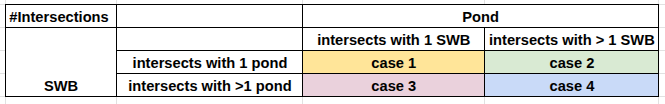

In [22]:
intersections_gdf = swb_gdf.sjoin(ponds_gdf)

In [23]:
# ponds_gdf

In [24]:
intersections_gdf.shape

(1067, 38)

In [25]:
# ponds_gdf

In [26]:
swb_intersections_df = intersections_gdf.groupby(['UID'])['pond_id'].unique().reset_index()

In [27]:
pond_intersections_df = intersections_gdf.groupby(['pond_id'])['UID'].unique().reset_index()

In [28]:
merged_gdf.shape

(6373, 37)

In [29]:
single_intersection_uids = [row['UID'] for ind,row in swb_intersections_df.iterrows() if len(row['pond_id']) == 1]

In [30]:
len(single_intersection_uids)

1033

In [31]:
# single_intersection_uids

In [32]:
# pond_intersections_df

In [33]:
case_1_swb_ids = []
for x in single_intersection_uids:
    for y in pond_intersections_df['UID']:
        if (x in y):
            if (len(y) == 1):
                case_1_swb_ids.append(x)

In [34]:
len(case_1_swb_ids)

923

In [35]:
# ponds_gdf

In [36]:
case1_gdf = swb_gdf[swb_gdf['UID'].isin(case_1_swb_ids)].sjoin(
    ponds_gdf,
    how='left'
)

In [37]:
case1_gdf.drop(['index_right'],axis=1,inplace=True)

In [38]:
for index,row in case1_gdf.iterrows():
    case1_gdf.loc[index,'geometry'] = shapely.ops.unary_union(
        [
            row['geometry'],
            ponds_gdf[ponds_gdf['pond_id'] == row['pond_id']]['geometry'].iloc[0]
        ]
    ) #new find: without the .loc it wont update the original value of the row geometries. like row['geometry] = unary_union(row['geometry'],pond['geometry']) didnt update the value


In [39]:
merged_gdf = \
    pd.concat(
        [
            merged_gdf,
            case1_gdf
        ]
)

In [40]:
merged_gdf.shape

(7296, 37)

Case 2: Cases of ponds intersecting with more than 1 SWBs, and SWBs intersecting with only 1 pond
- In these cases we currently dont merge the boundary of the intersecting pond and swbs, but just tag the pond which intersects with an SWB, and have 1 row per SWB. 

In [41]:
single_intersection_pond_ids = [row['pond_id'] for ind,row in pond_intersections_df.iterrows() if len(row['UID']) == 1]
#ponds that intersect with only 1 swb

multi_intersection_pond_ids = [row['pond_id'] for ind,row in pond_intersections_df.iterrows() if len(row['UID']) > 1]
#ponds that intersect with only 1 swb

In [42]:
print(len(single_intersection_pond_ids))
print(len(multi_intersection_pond_ids))

956
52


In [43]:
# pond_intersections_df

In [44]:
# swb_intersections_df

In [45]:
case2_swb_ids = []
for x in single_intersection_uids:
    for y in pond_intersections_df['UID']:
        if (x in y):
            if (len(y) > 1):
                case2_swb_ids.append(x)

In [46]:
len(case2_swb_ids)

110

In [47]:
case2_gdf = swb_gdf[swb_gdf['UID'].isin(case2_swb_ids)].sjoin(
    ponds_gdf,
    how='left'
)

In [48]:
# case2_gdf.head()

In [49]:
case2_gdf.drop(['index_right'],axis=1,inplace=True)

In [50]:
case2_gdf.shape

(110, 37)

In [51]:
merged_gdf = \
    pd.concat(
        [
            merged_gdf,
            case2_gdf
        ]
)

In [52]:
merged_gdf.shape

(7406, 37)

Case 3: Cases of SWB intersecting with more than 1 ponds, and the corresponding ponds intersecting with only 1 SWB  
Case 4: Cases of SWB intersecting with more than 1 ponds, and the corresponding ponds intersecting with more than 1 SWB  

It makes sense to combine these cases wrt the dataframe

In [53]:
multi_intersection_uids = [row['UID'] for ind,row in swb_intersections_df.iterrows() if len(row['pond_id']) > 1]

In [54]:
multi_intersection_uids

['6_1084_6_1421_6_4571_8025',
 '6_3181_137',
 '6_3812_6_3894_6_3938_6_3991_6_4133_6_4254_6_4092_148',
 '6_4284_6_4311_8051',
 '6_437_6_1454_6_1610_6_1777_6_1889_6_2036_6_2183_6_2403_6_2462_6_2495_6_3558_6_438_6_1086_149',
 '6_440_6_1088_6_1291_6_1556_6_2706_6_2785_6_2831_6_2909_6_2954_6_2960_6_2999_6_3154_6_3181_6_3196_6_3350_6_3424_6_3458_6_3491_6_3500_6_3526_6_3546_6_3930_6_4747_6_4777_6_5011_6_1710_6_2867_6_2920_6_3050_6_3295_150']

In [55]:
case3_4_swb_ids = []
case3_4_pond_ids = []
for x in multi_intersection_uids:
    for ind,row in pond_intersections_df.iterrows():
        if (x in row['UID']):
            if (len(row['UID']) >= 1):
                # print(row['pond_id'])
                case3_4_swb_ids.append(x)
                case3_4_pond_ids.append(row['pond_id'])

In [56]:
len(case3_4_swb_ids) #again these are intersections, not unique swb ids

34

In [57]:
case3_4_gdf = swb_gdf[swb_gdf['UID'].isin(case3_4_swb_ids)].sjoin(
    ponds_gdf[ponds_gdf['pond_id'].isin(case3_4_pond_ids)],
    how='left'
)

Create merged geometry and add comma separated pond ids

In [59]:
swb_ponds_case3_4 = case3_4_gdf.groupby(['UID'])['pond_id'].agg(set).reset_index()
swb_ponds_case3_4

,UID,pond_id
0,6_1084_6_1421_6_4571_8025,"{2625, 2609}"
1,6_3181_137,"{1569, 1562}"
2,6_3812_6_3894_6_3938_6_3991_6_4133_6_4254_6_40...,"{1336, 1418, 1238, 1158}"
3,6_4284_6_4311_8051,"{2555, 2574}"
4,6_437_6_1454_6_1610_6_1777_6_1889_6_2036_6_218...,"{2281, 2579, 2924, 3167}"
5,6_440_6_1088_6_1291_6_1556_6_2706_6_2785_6_283...,"{2176, 2064, 2066, 1443, 1830, 2095, 1971, 133..."


In [61]:
swb_ponds_case3_4['pond_id'] = swb_ponds_case3_4['pond_id'].apply(lambda x: list(x))

In [62]:
case3_4_dict = swb_ponds_case3_4.set_index('UID').T.to_dict('list')

In [64]:
# case3_dict

In [63]:
case3_4_dict.values()

dict_values([[[2625, 2609]], [[1569, 1562]], [[1336, 1418, 1238, 1158]], [[2555, 2574]], [[2281, 2579, 2924, 3167]], [[2176, 2064, 2066, 1443, 1830, 2095, 1971, 1334, 1853, 1218, 2122, 1356, 1869, 1755, 2012, 2142, 1249, 1388, 1773, 1774]]])

Learning:
* Apparently list/set or any multiple values is not a good idea to assign to a cell in pandas.  

- https://stackoverflow.com/questions/53116286/how-to-assign-an-entire-list-to-each-row-of-a-pandas-dataframe
- https://stackoverflow.com/questions/52552198/how-to-set-the-value-of-a-pandas-column-as-list/52563718#52563718

So this is a TODO for later. 
For now, I will keep it as a list. 

In [64]:
case3_4_merged_geom = []
for swb in swb_ponds_case3_4['UID']:
    #get corresponding farmpond geometries and merge them 
    # print(swb)
    merged_geom = swb_gdf[swb_gdf['UID'] == swb]['geometry'].iloc[0]
    # print(merged_geom)
    # case3_gdf.loc[case3_gdf['UID'] == swb,'pond_id'] = np.nan
    for pond in list(swb_ponds_case3_4[swb_ponds_case3_4['UID'] == swb]['pond_id'].iloc[0]):
        merged_geom = shapely.ops.unary_union(
            [
                merged_geom,
                ponds_gdf[ponds_gdf['pond_id'] == pond]['geometry'].iloc[0]
            ])
    case3_4_merged_geom.append(merged_geom)
    case3_4_gdf.loc[case3_4_gdf['UID'] == swb,'geometry'] = merged_geom

Keep only 1 row per SWB

In [65]:
case3_4_gdf = case3_4_gdf.groupby(['UID']).first().reset_index()

In [66]:
case3_4_gdf.drop(['index_right'],axis=1,inplace=True)

In [71]:
case3_4_gdf.drop(['pond_id'],axis=1,inplace=True)

In [72]:
case3_4_gdf = case3_4_gdf.merge(swb_ponds_case3_4,
                how='left')

In [73]:
merged_gdf = \
    pd.concat(
        [
            merged_gdf,
            case3_4_gdf
        ]
)

/home/nirzaree/miniconda3/envs/.ponds_n_wells/lib/python3.12/site-packages/geopandas/array.py:1638: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  return GeometryArray(data, crs=_get_common_crs(to_concat))


In [74]:
merged_gdf.shape

(7412, 37)